# 反距离加权法实现插值

参考什么书本啊，我就知道这么经典的算法肯定有人做了（狗头）。

本实验参考 [这个 Gist](https://gist.github.com/Majramos/5e8985adc467b80cccb0cc22d140634e)。哇塞，直接狠狠使用并改造！

那啥，我肯定没这本事整这么大的活，所以除了这个 Gist 之外还是请教了 Copilot 大人的。

## 参数设置
- **DEM范围**: 15m × 15m
- **分辨率**: 0.5m
- **离散点数**: 20
- **搜索半径(r)**: 5
- **幂参数(k)**: 2

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['HarmonyOS Sans SC'] # 经典字体，不得不品
plt.rcParams['axes.unicode_minus'] = False

In [16]:
# 离散高程点 (x, y, elevation)
points = np.array([
    [0, 0, 50], [5, 0, 80], [10, 0, 100], [15, 0, 200],
    [0, 5, 60], [5, 5, 120], [10, 5, 150], [15, 5, 180],
    [0, 10, 70], [5, 10, 140], [10, 10, 160], [15, 10, 210],
    [0, 15, 100], [5, 15, 130], [10, 15, 170], [15, 15, 250],
    [8, 8, 190], [12, 12, 220], [2, 13, 110], [7, 3, 90]
])

print("离散高程点数据:")
print(points)
print(f"\n点的数量: {len(points)}")
print(f"X坐标范围: {points[:, 0].min():.0f} - {points[:, 0].max():.0f}")
print(f"Y坐标范围: {points[:, 1].min():.0f} - {points[:, 1].max():.0f}")
print(f"高程范围: {points[:, 2].min():.0f} - {points[:, 2].max():.0f} m")

离散高程点数据:
[[  0   0  50]
 [  5   0  80]
 [ 10   0 100]
 [ 15   0 200]
 [  0   5  60]
 [  5   5 120]
 [ 10   5 150]
 [ 15   5 180]
 [  0  10  70]
 [  5  10 140]
 [ 10  10 160]
 [ 15  10 210]
 [  0  15 100]
 [  5  15 130]
 [ 10  15 170]
 [ 15  15 250]
 [  8   8 190]
 [ 12  12 220]
 [  2  13 110]
 [  7   3  90]]

点的数量: 20
X坐标范围: 0 - 15
Y坐标范围: 0 - 15
高程范围: 50 - 250 m


## 反距离加权法(IDW)的算法原理

基本公式：

> 我还会打 $\LaTeX$ 公式，非常好啊嗯

$$Z(x,y) = \frac{\sum_{i=1}^{n} w_i \cdot Z_i}{\sum_{i=1}^{n} w_i}$$

其中:
- $Z(x,y)$ 是待插值点的值
- $Z_i$ 是已知点i的值
- $w_i$ 是权重，定义为: $w_i = \frac{1}{d_i^p}$
- $d_i$ 是待插值点到已知点i的欧氏距离
- $p$ 是幂参数（通常取2）

### 特点:
- 计算简单，速度快  
- 近处点影响大，远处点影响小（局部性强）  
- 不会产生极值（插值值在已知值范围内）  
- 适合不规则离散点的空间插值

In [17]:
def inverse_distance_weighted_interpolation(points, grid_shape=(15, 15), 
                                           cell_size=0.5, k=2, search_radius=5):
    """
    反距离加权法(IDW)插值
    
    参数:
    - points: 离散点数组，格式 [[x1, y1, z1], [x2, y2, z2], ...]
    - grid_shape: 输出DEM的形状 (width, height)
    - cell_size: 网格单元大小
    - k: 搜索半径内使用的最近邻点数量
    - search_radius: 搜索半径大小
    
    返回:
    - dem: 插值后的二维数组 (高程值)
    """
    width, height = grid_shape
    dem = np.zeros((height, width))
    
    # 生成网格坐标
    x_coords = np.arange(0, width * cell_size, cell_size)
    y_coords = np.arange(0, height * cell_size, cell_size)
    
    # 对每个网格点进行插值
    for i, y in enumerate(y_coords):
        for j, x in enumerate(x_coords):
            # 计算到所有离散点的距离
            distances = np.sqrt((points[:, 0] - x)**2 + (points[:, 1] - y)**2)
            
            # 找到搜索半径内的点
            mask = distances <= search_radius
            nearby_indices = np.where(mask)[0]
            
            # 如果没有找到邻近点，使用最近的k个点
            if len(nearby_indices) == 0:
                nearby_indices = np.argsort(distances)[:k]
            
            nearby_distances = distances[nearby_indices]
            nearby_elevations = points[nearby_indices, 2]
            
            # 处理精确点（距离为0）
            if np.any(nearby_distances == 0):
                dem[i, j] = nearby_elevations[nearby_distances == 0][0]
            else:
                # 反距离加权插值，权重为 1/distance^2
                weights = 1 / (nearby_distances ** 2)
                weights = weights / np.sum(weights)  # 归一化权重
                dem[i, j] = np.sum(weights * nearby_elevations)
    
    return dem

In [18]:
# 生成DEM
dem = inverse_distance_weighted_interpolation(
    points,
    grid_shape=(15, 15),
    cell_size=0.5,
    k=2,
    search_radius=5
)

x_grid = np.arange(0, 15.0 + 0.5, 0.5)
y_grid = np.arange(0, 15.0 + 0.5, 0.5)
X, Y = np.meshgrid(x_grid, y_grid)

In [19]:
print("\nDEM二维数组 (高程单位: 米):")
print("="*100)
np.set_printoptions(precision=2, suppress=True, linewidth=120)
print(dem)
print("="*100)


DEM二维数组 (高程单位: 米):
[[ 50.    50.37  51.76  54.66  59.23  65.    72.69  76.55  78.82  79.8   80.    80.45  81.94  84.28  87.06]
 [ 50.12  50.93  52.55  55.42  59.5   65.    77.34  79.86  80.71  80.59  80.71  81.85  84.29  87.25  89.94]
 [ 50.59  52.23  53.81  56.42  66.15  73.05  77.05  81.09  81.95  82.01  83.16  84.68  86.76  88.99  94.53]
 [ 51.55  54.07  55.48  64.01  68.4   74.83  78.55  81.2   84.3   84.74  87.09  88.45  89.64  93.73  94.94]
 [ 53.08  56.03  63.59  66.87  70.83  76.93  80.63  83.52  85.51  88.55  91.49  91.88  94.38  93.89  93.87]
 [ 55.    55.    66.06  69.17  73.09  79.15  83.2   86.62  89.18  96.67  95.76  94.35  95.07  92.62  91.51]
 [ 56.92  63.62  67.18  70.47  76.45  81.27  86.1   90.42  93.79  98.7  100.45 100.19  96.04  91.85  90.  ]
 [ 58.45  63.56  65.78  70.64  75.83  83.11  89.13  94.73 102.51 104.55 106.44 105.   102.42  96.12  93.34]
 [ 59.41  62.43  64.76  69.09  76.15  84.56  92.01 102.5  107.62 111.   115.62 114.34 109.65 104.46 102.27]
 [ 59.88

## DEM可视化 - 热力图

这玩意 AI 写的。我懒了（）

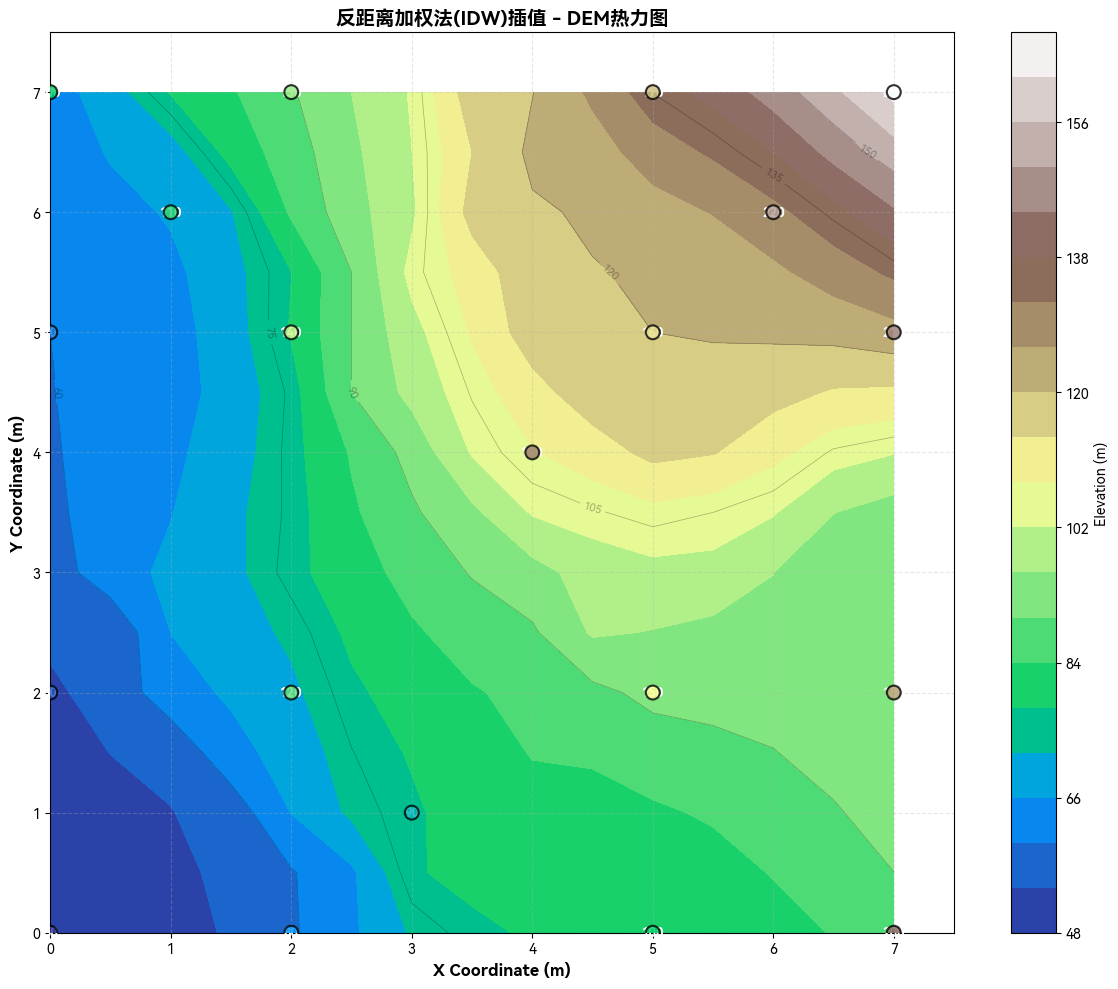

In [23]:
# 创建热力图可视化
fig, ax = plt.subplots(figsize=(12, 10))

# 生成网格
x_grid = np.arange(0, 15 * 0.5, 0.5)
y_grid = np.arange(0, 15 * 0.5, 0.5)
x_max = x_grid[-1] + 0.5
y_max = y_grid[-1] + 0.5
X, Y = np.meshgrid(x_grid, y_grid)

# 绘制等高线和填充颜色
im = ax.contourf(X, Y, dem, levels=20, cmap='terrain', extent=[0, x_max, 0, y_max])
contours = ax.contour(X, Y, dem, levels=10, colors='black', alpha=0.3, linewidths=0.5, extent=[0, x_max, 0, y_max])
ax.clabel(contours, inline=True, fontsize=8, fmt='%.0f')

# 标注离散点（缩放坐标到网格范围）
points_scaled = points.copy()
points_scaled[:, 0] = points[:, 0] * 0.5  # x坐标缩放
points_scaled[:, 1] = points[:, 1] * 0.5  # y坐标缩放
scatter = ax.scatter(points_scaled[:, 0], points_scaled[:, 1], c=points[:, 2], 
                    s=100, marker='o', edgecolors='black', linewidths=1.5,
                    cmap='terrain', zorder=5, alpha=0.8)
for idx, point in enumerate(points_scaled):
    ax.annotate(f"{int(points[idx, 2])}", (point[0], point[1]), 
               fontsize=9, ha='center', va='center', fontweight='bold', color='white')

ax.set_xlabel('X Coordinate (m)', fontsize=12, fontweight='bold')
ax.set_ylabel('Y Coordinate (m)', fontsize=12, fontweight='bold')
ax.set_title('反距离加权法(IDW)插值 - DEM热力图', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)
cbar = plt.colorbar(im, ax=ax, label='Elevation (m)')

plt.tight_layout()
plt.show()

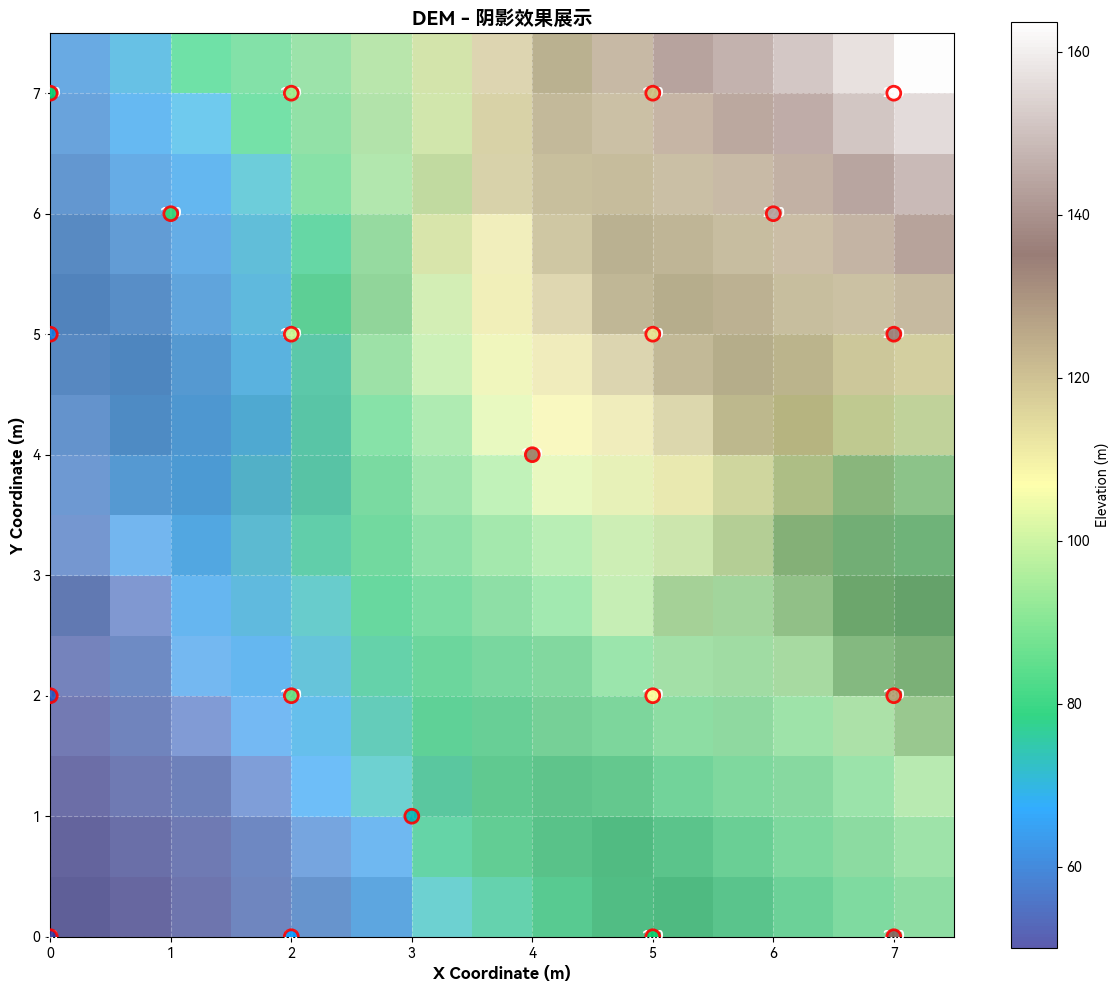

In [24]:
# 创建带阴影效果的DEM可视化
fig, ax = plt.subplots(figsize=(12, 10))

# 生成网格
x_grid = np.arange(0, 15 * 0.5, 0.5)
y_grid = np.arange(0, 15 * 0.5, 0.5)
x_max = x_grid[-1] + 0.5
y_max = y_grid[-1] + 0.5

# 使用阴影效果增强立体感
ls = LightSource(azdeg=315, altdeg=45)
shaded = ls.hillshade(dem, vert_exag=0.1)

# 绘制DEM和阴影，extent范围应与实际网格范围一致
im = ax.imshow(dem, extent=[0, x_max, 0, y_max], origin='lower', 
              cmap='terrain', alpha=0.8)
ax.imshow(shaded, extent=[0, x_max, 0, y_max], origin='lower', 
         cmap='gray', alpha=0.3)

# 标注离散点（缩放坐标到网格范围）
points_scaled = points.copy()
points_scaled[:, 0] = points[:, 0] * 0.5  # x坐标缩放
points_scaled[:, 1] = points[:, 1] * 0.5  # y坐标缩放
scatter = ax.scatter(points_scaled[:, 0], points_scaled[:, 1], c=points[:, 2], 
                    s=100, marker='o', edgecolors='red', linewidths=2,
                    cmap='terrain', zorder=5, alpha=0.9)
for idx, point in enumerate(points_scaled):
    ax.annotate(f"{int(points[idx, 2])}", (point[0], point[1]), 
               fontsize=9, ha='center', va='center', fontweight='bold', color='white')

ax.set_xlabel('X Coordinate (m)', fontsize=12, fontweight='bold')
ax.set_ylabel('Y Coordinate (m)', fontsize=12, fontweight='bold')
ax.set_title('DEM - 阴影效果展示', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', color='white')
cbar = plt.colorbar(im, ax=ax, label='Elevation (m)')
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

## 简答题

**参数优化方案**

1. 变动幂参数(p值)
   - 增大p值(如 p=3, p=4)：近处点权重急剧增大，远处点权重急剧降低，更强的局部性
   - 减小p值(如 p=1)：各点权重差异减小，远处点影响仍然较大

2. 自适应权重函数
   - 使用指数衰减：$w_i = \exp(-\alpha \cdot d_i)$
   - 使用高斯函数：$w_i = \exp(-(d_i^2/\sigma^2))$

3. 增大幂参数同时减小搜索半径
   - 也许能行的优化方案：`p=3, search_radius=4`

**算法优化方案**

1. K-D树或四叉树加速
   - 预构建空间索引结构，快速定位搜索范围内的点

2. 并行计算
   - 使用多线程/多进程处理各网格点

3. 分块处理(Tiling)
   - 将大DEM分成小块，分别处理
   - 降低内存占用，便于并行处理